## FDI Regression Modeling and Time-Series Data
- Regression modeling between FDI and economic freedom indicators
- Time-series data for FDI

In [1]:
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
import mysql.connector
from mysql.connector import Error
import os

env = os.environ

MYSQL_CONFIG = {
    'host': env.get("MYSQL_HOST"),
    'user': env.get("MYSQL_USER"), 
    'password': env.get("MYSQL_PW"),
    'database': env.get("MYSQL_DB")
}

# oecd_path = "C:\\Users\\Harb\\OneDrive\\Documents\\foreign-direct-investment-analysis\\data\\processed\\political_factors\\OECD_fdi_flows_fdi_restrictiveness.csv"
# economic_freedom_path = "C:\\Users\\Harb\\OneDrive\\Documents\\foreign-direct-investment-analysis\\data\\processed\\political_factors\\economic_freedom_country_scores.csv"

# oecd_df = pd.read_csv(oecd_path)
# economic_freedom_df = pd.read_csv(economic_freedom_path)


def get_mysql_connection(config):
    try:
        connection = mysql.connector.connect(
            host=config['host'],
            user=config['user'],
            password=config['password'],
            database=config['database']
        )
        if connection.is_connected():
            print("connected to MySQL server")
        return connection
    except Error as e:
        print(f"Error: {e}")
        return None

def table_to_dataframe(connection, table_name, query=None):
    try:
        if query is None:
            query = f"SELECT * FROM {table_name}"
        
        df = pd.read_sql(query, connection)
        print(f"Got {len(df)} rows from {table_name}")
        return df
    except Error as e:
        print(f"Couldn't retrieve data from {table_name}: {e}")
        return None

connection = get_mysql_connection(MYSQL_CONFIG)
    
if connection:
    try:
        fdi_data = table_to_dataframe(connection, 'fdi_data')
        economic_freedom_data = table_to_dataframe(connection, 'economic_freedom_country_scores')
                    
    finally:
        connection.close()
        print("MySQL connection closed.")

connected to MySQL server
Got 75 rows from fdi_data
Got 60 rows from economic_freedom_country_scores
MySQL connection closed.


C:\Users\Harb\AppData\Local\Temp\ipykernel_28316\2011831281.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
C:\Users\Harb\AppData\Local\Temp\ipykernel_28316\2011831281.py:41: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


In [3]:

# economic_freedom_file = "C:\\Users\\Harb\\OneDrive\\Documents\\foreign-direct-investment-analysis\\data\\processed\\political_factors\\economic_freedom_country_scores.csv"
# fdi_data_file = "C:\\Users\\Harb\\OneDrive\\Documents\\foreign-direct-investment-analysis\\data\\processed\\fdi_data\\fdi_data.csv"

# economic_freedom_data = pd.read_csv(economic_freedom_file)
# fdi_data = pd.read_csv(fdi_data_file)

economic_freedom_data.head(), fdi_data.head()

(   Unnamed: 0 name_web    Year  Overall  Property Rights  \
 0        34.0    china  2024.0     48.5             46.9   
 1        74.0    india  2024.0     52.9             49.2   
 2       218.0    china  2023.0     48.3             45.3   
 3       258.0    india  2023.0     52.9             49.7   
 4       402.0    china  2022.0     48.0             43.7   
 
    Government Integrity  Judicial Effectiveness  Tax Burden  \
 0                  41.6                    39.5        69.1   
 1                  40.8                    52.1        73.7   
 2                  38.2                    42.0        69.5   
 3                  53.0                    42.2        78.5   
 4                  39.3                    37.4        71.2   
 
    Government Spending  Fiscal Health  Business Freedom  Trade Freedom  \
 0                 65.7            8.1              68.1           73.6   
 1                 73.5            6.9              68.3           62.2   
 2                 65

### Additional Preprocessing

In [ ]:
fdi_data['Year'] = fdi_data['Year'].astype(int)
economic_freedom_data['Year'] = economic_freedom_data['Year'].astype(int)

country_code_map = {'CHINA': 'CHN', 'INDIA': 'IND'}
economic_freedom_data['Country Code'] = economic_freedom_data['name_web'].str.upper().map(country_code_map)

merged_data = pd.merge(
    fdi_data,
    economic_freedom_data,
    on=['Year', 'Country Code'],
    how='inner'
)

merged_data.head(10)

,Year,Country Code,GDP (Billion USD),FDI Percentage,Absolute FDI (Billion USD),Unnamed: 0,name_web,Overall,Property Rights,Government Integrity,Judicial Effectiveness,Tax Burden,Government Spending,Fiscal Health,Business Freedom,Trade Freedom,Monetary Freedom,Investment Freedom,Financial Freedom,Labor Freedom
0,1995,CHN,731.00,4.880863,35.679110,5370,china,52.0,30.0,30.0,NaN,70.6,93.7,NaN,55.0,20.0,68.4,50.0,50.0,NaN
1,1996,CHN,860.47,4.651813,40.027452,5187,china,51.3,30.0,30.0,NaN,70.7,94.6,NaN,55.0,20.0,61.5,50.0,50.0,NaN
2,1997,CHN,957.99,4.725344,45.268321,5004,china,51.7,30.0,22.0,NaN,70.4,95.4,NaN,55.0,30.0,62.7,50.0,50.0,NaN
3,1998,CHN,1024.17,4.435501,45.427071,4821,china,53.1,30.0,24.0,NaN,70.5,95.9,NaN,55.0,34.0,68.2,50.0,50.0,NaN
4,1999,CHN,1088.35,3.748981,40.802037,4638,china,54.8,30.0,29.0,NaN,70.5,95.1,NaN,55.0,38.2,75.2,50.0,50.0,NaN
5,2000,CHN,1205.53,3.475126,41.893685,4455,china,56.4,30.0,35.0,NaN,70.4,90.3,NaN,55.0,42.6,84.0,50.0,50.0,NaN
6,2001,CHN,1333.65,3.512989,46.850972,4272,china,52.6,30.0,34.0,NaN,70.4,94.1,NaN,55.0,46.0,84.1,30.0,30.0,NaN
7,2002,CHN,1465.83,3.609081,52.902994,4089,china,52.8,30.0,31.0,NaN,70.3,92.3,NaN,55.0,48.6,87.6,30.0,30.0,NaN
8,2003,CHN,1656.96,3.487419,57.785136,3906,china,52.6,30.0,35.0,NaN,66.9,90.2,NaN,55.0,50.6,85.8,30.0,30.0,NaN
9,2004,CHN,1949.45,3.483642,67.911850,3723,china,52.5,30.0,35.0,NaN,66.4,88.4,NaN,55.0,51.4,86.4,30.0,30.0,NaN


### Note 
- regression was initially being performed on FDI as a percentage of GDP
- this must be changed to Absolute FDI to provide meaningful results in the provided context

In [41]:
regression_data = merged_data.dropna()  
X = regression_data[['Overall', 'Property Rights', 'Government Integrity', 
                     'Business Freedom', 'Trade Freedom', 'Investment Freedom']]
y = regression_data['Absolute FDI (Billion USD)']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                                OLS Regression Results                                
Dep. Variable:     Absolute FDI (Billion USD)   R-squared:                       0.917
Model:                                    OLS   Adj. R-squared:                  0.834
Method:                         Least Squares   F-statistic:                     11.06
Date:                        Wed, 11 Dec 2024   Prob (F-statistic):            0.00501
Time:                                20:39:06   Log-Likelihood:                -62.169
No. Observations:                          13   AIC:                             138.3
Df Residuals:                               6   BIC:                             142.3
Df Model:                                   6                                         
Covariance Type:                    nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

C:\Users\Harb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
china_fdi = merged_data[merged_data['Country Code'] == 'CHN']
india_fdi = merged_data[merged_data['Country Code'] == 'IND']

china_fdi.set_index('Year', inplace=True)
india_fdi.set_index('Year', inplace=True)

# since seasonal_periods must be set, I will use 5 years and use the same value for China and India
seasonal_periods = 5 


### Holt-Winters Model

In [ ]:
china_hw_model = ExponentialSmoothing(
    china_fdi['Absolute FDI (Billion USD)'], 
    trend='add', 
    seasonal=None,
    seasonal_periods=seasonal_periods
).fit()

india_hw_model = ExponentialSmoothing(
    india_fdi['Absolute FDI (Billion USD)'], 
    trend='add', 
    seasonal=None,
    seasonal_periods=seasonal_periods
).fit()

china_forecast = china_hw_model.forecast(steps=5)
india_forecast = india_hw_model.forecast(steps=5)

print(china_forecast)
print(india_forecast)

28    251.164309
29    258.976093
30    266.787876
31    274.599660
32    282.411444
dtype: float64
29    34.476196
30    35.597084
31    36.717972
32    37.838860
33    38.959747
dtype: float64


C:\Users\Harb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Harb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\Harb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results

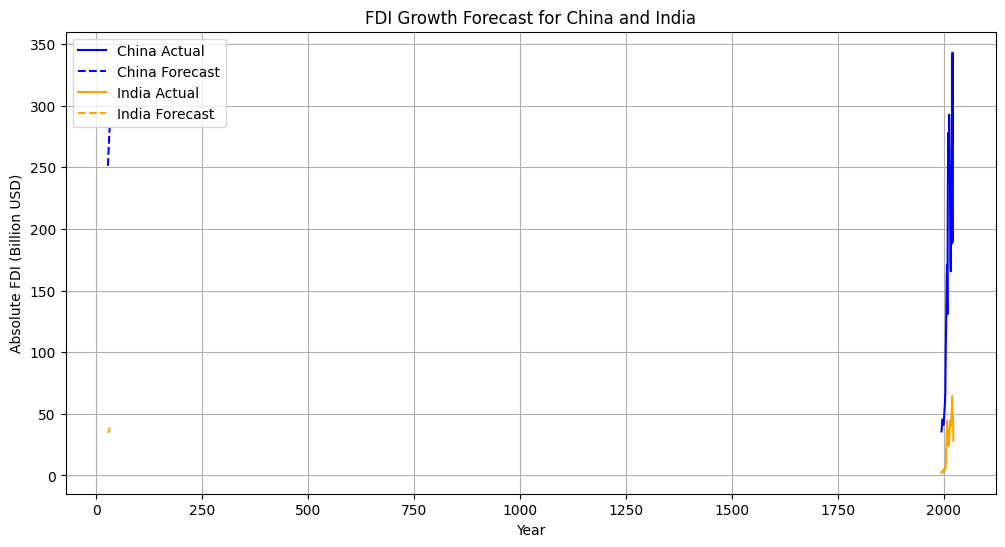

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(china_fdi['Absolute FDI (Billion USD)'], label="China Actual", color='blue')
plt.plot(china_forecast, label="China Forecast", linestyle="--", color='blue')

plt.plot(india_fdi['Absolute FDI (Billion USD)'], label="India Actual", color='orange')
plt.plot(india_forecast, label="India Forecast", linestyle="--", color='orange')

plt.title("FDI Growth Forecast for China and India")
plt.xlabel("Year")
plt.ylabel("Absolute FDI (Billion USD)")
plt.legend()
plt.grid(True)
plt.show()